<a href="https://colab.research.google.com/github/alejandromanas/GoogleColab_public/blob/master/bookings/code/bookings_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Booking cancellation prediction**

Before you begin, I recommend you to open this notebook in Google colab. You will be able to run python code without having a powerful computer and you can browse quickly through different sections of the document.


Booking cancellations generates a big impact on transport and hotel industries and contributes negatively to the generation of accurate forecasts. Cancellation rate can range from 20% to 60% depending on the hotel type and location. A good predictive model of cancellation could reduces losses ensuring better decision-making in the following areas:

* Booking management- Get a better forecast of net demand (bookings - cancellations)

* Revenue Management- Improves information quality (net demand) to optimize pricing management

* Resource management- Optimize purchasing planning, services of external suppliers and staff organization. 

* Overbooking policies- Reduce the additional costs of acomodate guests in other hotels and the loss of confidence and bad publicity (bad reviews) that it can cause.

The purpose of this notebook is to show several supervised classification models that allows to predict if a hotel booking will be canceled in the future. 

The algorithms used are: 
* Logistic regression
* SVM (Support Vector Machine)
* XGBoost
* LightGBM 
* Neural network

### Loading Data

Data used was obtained from an article entitled "Hotel booking demand datasets"  and written by Nuno Antonio, Anade Almeid and Luis Nunes (https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The article includes a dataset with 120,000 reservations from two hotels of one of the major portuguese hotels brand. Both hotels have more than 200 rooms and a four stars rating. One is a city hotel located in Lisbon and the other is a resort hotel in the Algarve. The reservations have an arrival date between 1st July 2015 and 31th August 2017. 

Each reservation includes about 31 features or columns. Some of them are:
* Booking status (cancelled or not cancelled)
* Lead time
* Number of nights (weekdays and weekends)
* Average price per night
* Distribution channel
* Market segment
* Room type
* Number of guests (babes, childs or adults)

Importing data from public github repository 

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

H1 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H1.csv", delimiter = ',')
H1['Hotel']='Resort'

#outcome 'IsCancelled'
H2 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H2.csv", delimiter = ',')
H2['Hotel']='Urban'

df_raw=[]
df_raw=pd.concat([H1,H2], axis=0,ignore_index=True)

### Data Analysis

**Data overview**

In [2]:
df_analysis = df_raw.copy()
df_analysis.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [3]:
df_analysis.groupby('IsCanceled').mean()

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
IsCanceled,,,,,,,,,,,,,,,,,
0,79.984687,2016.147514,27.080143,15.839529,0.928971,2.464053,1.829737,0.102347,0.010377,0.043344,0.015792,0.202977,0.293364,1.589868,99.987693,0.0993,0.714060
1,144.848815,2016.171920,27.309696,15.728066,0.925267,2.561912,1.901728,0.106513,0.003821,0.012482,0.208348,0.025122,0.098340,3.564083,104.964333,0.0000,0.328826


In [4]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13 

**Analysing cancelation rates**


Cancelation rate mean: 37.04


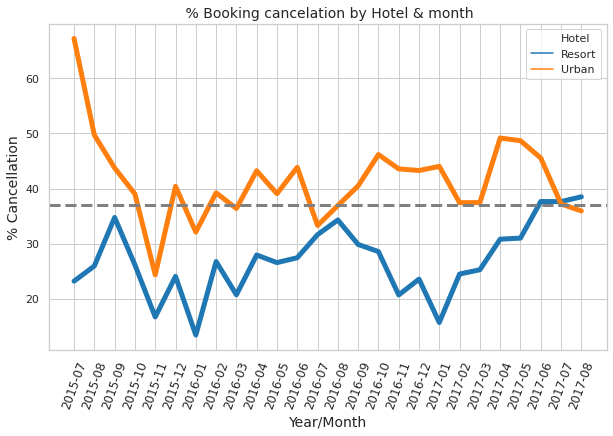

In [5]:
#overall cancelation rate
canc_rate=df_analysis.IsCanceled.sum()/len(df_analysis)*100
print('Cancelation rate mean: %.2f' % canc_rate)

df_analysis['ArrivalDateMonthNum']=df_analysis.ArrivalDateMonth.replace({ 'January' : '01', 'February' : '02', 'March' : '03', 'April' :'04', 'May': '05', 'June' : '06', 'July':'07', 'August' : '08', 'September' : '09', 'October' : '10', 'November': '11', 'December' : '12' })
df_analysis['ArrivalDateYearMonth'] = df_analysis['ArrivalDateYear'].astype('str')+'-'+ df_analysis['ArrivalDateMonthNum'].astype('str')

# GROUP BY
col_name= 'ArrivalDateYearMonth'
df=(df_analysis.groupby(['Hotel',col_name]).mean()['IsCanceled']*100).to_frame()
df.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x="ArrivalDateYearMonth", y="IsCanceled", hue="Hotel", data=df,linewidth=5,palette="tab10")
ax.set_title(' % Booking cancelation by Hotel & month',fontsize=14)
ax.set_xlabel('Year/Month',fontsize=14);
ax.set_ylabel('% Cancellation',fontsize=14);
ax.set_xticklabels(labels=df.ArrivalDateYearMonth,rotation=70,size=12);
#plt.plot([df.ArrivalDateYearMonth[0], canc_rate], [df.ArrivalDateYearMonth.iloc[-1], canc_rate], linewidth=2)
plt.axhline(y=canc_rate, color='grey', linestyle='--',linewidth=3)
plt.show()

**Agent**

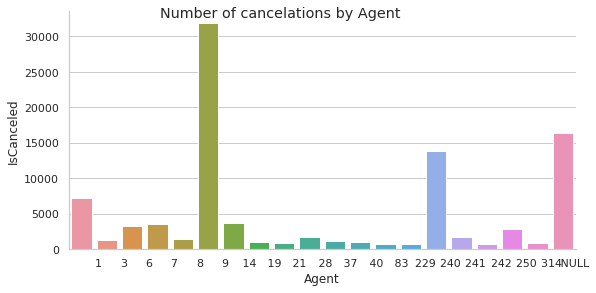

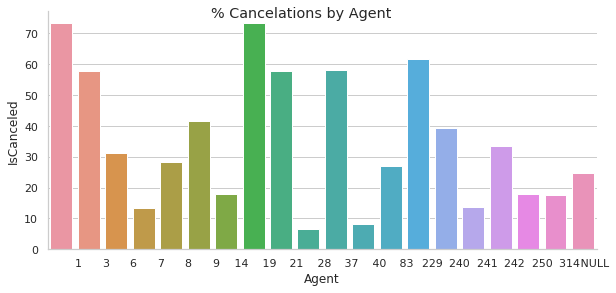

In [6]:
df_analysis.Agent.nunique() #334 unique values
n=20
def levels_analysis(feature,n):
  df=(df_analysis.groupby([feature]).count()['IsCanceled'].sort_values(ascending=False).head(n)).to_frame().reset_index()
  df=df.sort_values(by=feature)
  ax = sns.catplot(x=feature, y="IsCanceled", kind="bar", data=df)
  ax.fig.set_figwidth(10)
  ax.fig.set_figheight(4)
  ax.fig.suptitle('Number of cancelations by ' + feature)

  
  df_c=(df_analysis[df_analysis[feature].isin(df[feature].unique())].groupby(feature).mean()['IsCanceled']*100).to_frame().reset_index()
  df_c=df_c.sort_values(by=feature)
  ax = sns.catplot(x=feature, y="IsCanceled", kind="bar", data=df_c)
  ax.fig.set_figwidth(10)
  ax.fig.set_figheight(4)
  ax.fig.suptitle('% Cancelations by ' + feature)
  plt.show()

levels_analysis('Agent',20) # 20 greater agents by number of bookings

In [7]:
df=(df_analysis.groupby(['Agent']).count()['IsCanceled']/len(df_analysis))*100
df.sort_values(ascending=False).head(10)

Agent
          9    26.770249
       NULL    13.686238
        240    11.660943
          1     6.023118
         14     3.048832
          7     2.964235
          6     2.755675
        250     2.403886
        241     1.441494
         28     1.395427
Name: IsCanceled, dtype: float64

**Company**

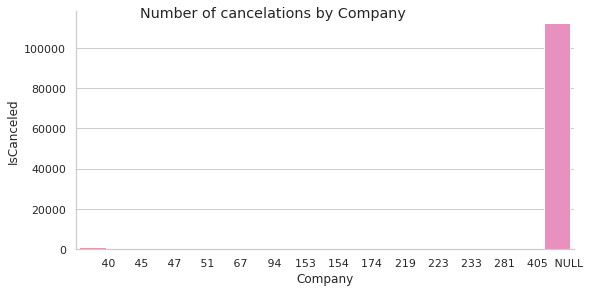

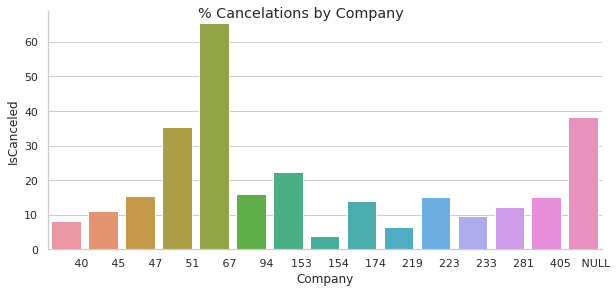

In [8]:
df_analysis.Company.nunique() #353 unique values

levels_analysis('Company',15) # 15 greater companies by number of bookings

In 94% of cases,Company is 'NULL'

In [9]:
  df=(df_analysis.groupby(['Company']).count()['IsCanceled']/len(df_analysis))*100
  df.sort_values(ascending=False).head(10)

Company
       NULL    94.306893
         40     0.776447
        223     0.656671
         67     0.223637
         45     0.209398
        153     0.180082
        174     0.124801
        219     0.118100
        281     0.115588
        154     0.111400
Name: IsCanceled, dtype: float64

**ADR (Average daily rate)**

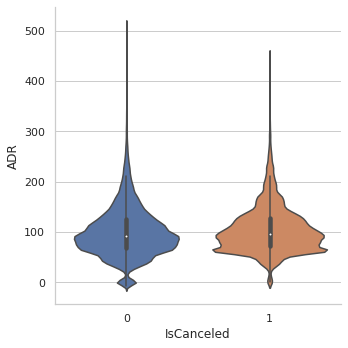

In [10]:
df=df_analysis[df_analysis['ADR']< 5000][['IsCanceled','ADR']]
#df.IsCanceled=df.IsCanceled.astype('str')
sns.catplot(x="IsCanceled", y="ADR", kind="violin", data=df)

ADR of 5400 EUR for 1 night x 2 Adults. Seems to be an error and will be deleted in preprocessing

In [11]:
df_analysis[df_analysis['ADR']> 5000]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel,ArrivalDateMonthNum,ArrivalDateYearMonth
48515,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12,NULL,0,Transient,5400.0,0,0,Canceled,2016-02-19,Urban,03,2016-03


Found booking with ADR **negative**. Sign reversed in preprocesing

In [12]:
index=df_analysis[df_analysis.ADR<0].index
df_analysis.ADR.loc[index]

14969   -6.38
Name: ADR, dtype: float64

**Lead time**

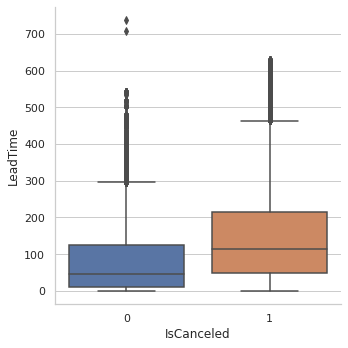

In [13]:
sns.catplot(x="IsCanceled", y="LeadTime", kind="box", data=df_analysis)

Lead time is diferent for canceled and not canceled bookings

**Booking changes**

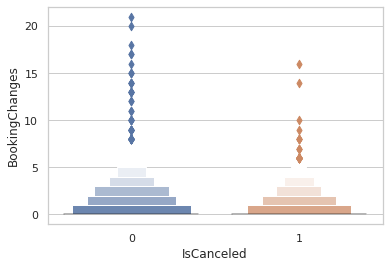

In [14]:
sns.boxenplot(x="IsCanceled", y="BookingChanges", scale="linear", data=df_analysis)

**Reservation Status**

In [15]:
df_analysis.ReservationStatus.value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: ReservationStatus, dtype: int64

Reservation Status is fixed after booking is closed (will be deleted in preprocessing)

### Preprocessing



Libraries & functions

In [0]:
#Libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
#from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

import warnings
warnings.filterwarnings("ignore")

# Metrics function

def clf_metrics(X,y,model):
  y_pred = pd.Series(model.predict(X))
  y_prob= model.predict_proba(X) 
    
  # Accuracy  
  print('Accuracy = %0.4f' % metrics.accuracy_score(y,y_pred))
        
  # AUC
  fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  print('AUC = %0.4f' % roc_auc)
        
  # Logloss
  Logloss = metrics.log_loss(y, y_prob[:,1])
  print('LogLoss = %0.4f' % Logloss)

  # F1-score
  F1_score = metrics.f1_score(y, y_pred)
  print('F1_score = %0.4f' % F1_score)

  # Mathews correlation      
  matthews_corr = metrics.matthews_corrcoef(y, y_pred)
  print('Matthews_corr = %0.4f' % matthews_corr)
  return y_pred,y_prob

  # Time execution mesure

def tic():
  global _start_time 
  _start_time = time.time()

def tac():
  t_sec = round(time.time() - _start_time)
  (t_min, t_sec) = divmod(t_sec,60)
  (t_hour,t_min) = divmod(t_min,60) 
  time_elapsed=print('Time elapsed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))


This section includes data manipulation & cleaning

In [17]:
#Preprocessing
df_data=[]
df_data=df_raw.copy()

# NAN
df_data.isnull().any() # nan found in Country & Children

# the value of the country is unreliable
# country is deleted
df_data.drop(columns = 'Country', inplace = True)

# nan in Children are replaced by 0
df_data.Children.replace(np.nan, 0,inplace = True)

# Month converted to numeric
#df_data['ArrivalDateMonthNum']=df_data.ArrivalDateMonth.replace({ 'January' : 1, 'February' : 2, 'March' : 3, 'April' :4, 'May': 5, 'June' : 6, 'July':7, 'August' : 8, 'September' : 9, 'October' : 10, 'November': 11, 'December' : 12 })
#df_data.drop(columns='ArrivalDateMonth',inplace=True)

# Deleting last booking change date
df_data.drop(columns = 'ReservationStatusDate', inplace = True)

#Deleting Reservation Status
df_data.drop(columns = ['ReservationStatus'], inplace = True)

#ADR negative 
index=df_data[df_data.ADR<0].index
df_data.ADR.loc[index]=df_data.ADR.loc[index]*-1

# ADR deleting outliers  >= 5000
df_data=df_data[df_data['ADR'] < 5000]

# Agent
#9
df_data["Agent_9"] = [1 if x == "          9" else 0 for x in df_data["Agent"]]
#null
df_data["Agent_null"] = [1 if x == "       NULL" else 0 for x in df_data["Agent"]]
#240
df_data["Agent_240"] = [1 if x == "        240" else 0 for x in df_data["Agent"]]
#1
df_data["Agent_1"] = [1 if x == "          1" else 0 for x in df_data["Agent"]]


df_data.drop(columns = 'Agent', inplace = True)

# Company
# Company null = 1, if Company is NULL 
df_data["Company_null"] = [1 if x == "       NULL" else 0 for x in df_data["Company"]]

df_data.drop(columns = 'Company', inplace = True)

# AssignedRoomType is fixed when the customer arrives to hotel (blank for cancelated bookings) 
df_data.drop(columns = 'AssignedRoomType', inplace = True)

#New dataframes

X=[] #features
y=[] #outcome
Z=[] #all

X=df_data.loc[:, df_data.columns != 'IsCanceled'] 
y=df_data['IsCanceled'] 
Z=df_data.copy() 

#dummification

X=pd.get_dummies(X,drop_first=True)
print(X.info())
#Spliting train, test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
y_train= y_train.to_numpy().ravel()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119389
Data columns (total 63 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   LeadTime                           119389 non-null  int64  
 1   ArrivalDateYear                    119389 non-null  int64  
 2   ArrivalDateWeekNumber              119389 non-null  int64  
 3   ArrivalDateDayOfMonth              119389 non-null  int64  
 4   StaysInWeekendNights               119389 non-null  int64  
 5   StaysInWeekNights                  119389 non-null  int64  
 6   Adults                             119389 non-null  int64  
 7   Children                           119389 non-null  float64
 8   Babies                             119389 non-null  int64  
 9   IsRepeatedGuest                    119389 non-null  int64  
 10  PreviousCancellations              119389 non-null  int64  
 11  PreviousBookingsNotCanceled        1193

### Logistic regresion

Logistic regresion analyzes a set of data points with one or more independent variables (input variables, which may affect the outcome) and finds the best fitting model to describe the data points, using the logistic regression equation: 

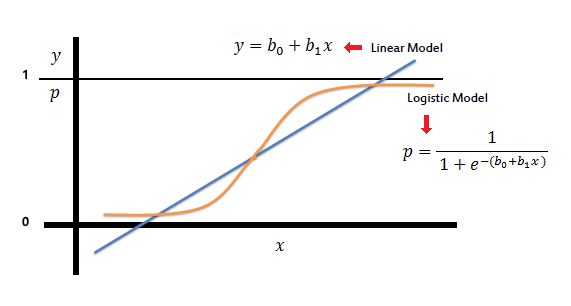

Correlation analysis


In [18]:
def get_correlations(df_x,df_y,col_outcome,n):
  df=pd.concat([df_x,df_y], axis=1)
  au_corr = df.corr().abs().unstack()
  df_corr = au_corr.to_frame().reset_index() #convert to dataframe
  df_corr.columns=['col_1','col_2','corr']
  df_corr = df_corr[df_corr.col_1 != df_corr.col_2] # excluding correlation with itself 
  df_corr = df_corr.sort_values(ascending=False, by=['corr'],ignore_index=True) #sort by correlation
  df_corr = df_corr.loc[::2] #exclude equal pairs
  df_corr = df_corr.reset_index(drop=True)        
  print('*** Correlations between features ***')
  df_corr_f = df_corr[(df_corr.col_1 != col_outcome) & (df_corr.col_2 != col_outcome)].head(n)
  df_corr_f= df_corr_f.sort_values(ascending=False, by=['corr'],ignore_index=True)
  print(df_corr_f)
  print('\n *** Correlations outcome vs features ***')
  df_corr_o = df_corr[(df_corr.col_1  == col_outcome) | (df_corr.col_2 == col_outcome)].head(n)
  df_corr_o = df_corr_o.sort_values(ascending=False, by=['corr'],ignore_index=True)
  print(df_corr_o)
  

get_correlations(X,y,'IsCanceled',20)

*** Correlations between features ***
                            col_1                        col_2      corr
0    CustomerType_Transient-Party       CustomerType_Transient  0.895595
1            MarketSegment_Direct   DistributionChannel_Direct  0.891460
2       DistributionChannel_TA/TO   DistributionChannel_Direct  0.797410
3         MarketSegment_Corporate                 Company_null  0.732110
4            MarketSegment_Direct    DistributionChannel_TA/TO  0.715917
5       DistributionChannel_TA/TO                   Agent_null  0.648411
6         MarketSegment_Online TA                      Agent_9  0.637837
7   DistributionChannel_Undefined      MarketSegment_Undefined  0.632448
8                      Agent_null                 Company_null  0.594200
9                         Agent_1         MarketSegment_Groups  0.566828
10                ArrivalDateYear        ArrivalDateWeekNumber  0.540566
11                    Hotel_Urban                    Agent_240  0.510334
12           

In [19]:
X_logreg = X.copy()

#ArrivalDateWeekNumber are highly correlated with ArrivalDateMonthNum
#X_logreg.drop(columns = 'ArrivalDateWeekNumber', inplace = True)

#CustomerType_Transient-Party are highly correlated with CustomerType_Transient
X_logreg.drop(columns = 'CustomerType_Transient-Party', inplace = True)
   
#DistributionChannel_Direct are highly correlated with MarketSegment_Direct
X_logreg.drop(columns = 'MarketSegment_Direct', inplace = True)

#DistributionChannel_TA/TO are highly correlated with DistributionChannel_Direct
X_logreg.drop(columns = 'DistributionChannel_TA/TO', inplace = True)

get_correlations(X_logreg,y,'IsCanceled',20)

*** Correlations between features ***
                                col_1                          col_2      corr
0             MarketSegment_Corporate                   Company_null  0.732110
1             MarketSegment_Online TA                        Agent_9  0.637837
2             MarketSegment_Undefined  DistributionChannel_Undefined  0.632448
3                          Agent_null                   Company_null  0.594200
4                MarketSegment_Groups                        Agent_1  0.566828
5                     ArrivalDateYear          ArrivalDateWeekNumber  0.540566
6                           Agent_240                    Hotel_Urban  0.510334
7                StaysInWeekendNights              StaysInWeekNights  0.498966
8             MarketSegment_Online TA    MarketSegment_Offline TA/TO  0.477954
9                MarketSegment_Groups    DepositType_Non Refund       0.464178
10                         Agent_null        MarketSegment_Corporate  0.458021
11            

Features Selection

In [20]:
from sklearn.feature_selection import RFE

#Recursive Feature Elimination (RFE)

logreg = LogisticRegression()
rfe = RFE(logreg,50)
rfe = rfe.fit(X_logreg, y)
#print(rfe.support_)
#print(rfe.ranking_)
print('selected features:',X_logreg.loc[:,rfe.support_].columns)
X_rfe=X_logreg.loc[:,rfe.support_]

selected features: Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'Children', 'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'Agent_9',
       'Agent_null', 'Agent_240', 'Agent_1', 'Company_null',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'Meal_FB       ', 'Meal_HB       ',
       'Meal_SC       ', 'Meal_Undefined', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Groups',
       'MarketSegment_Offline TA/TO', 'MarketSegment_Online TA',
       'DistributionChannel_Direct', 'DistributionChannel_GDS',
       'R

In [0]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X_rfe)
result=logit_model.fit(method='bfgs',maxiter=500)
#result=logit_model.fit()
print(result.summary2())

In [0]:
#Deleting Pvalues > 0.05
#drop_columns=['RequiredCarParkingSpaces','ArrivalDateMonth_January','ArrivalDateMonth_August','ArrivalDateMonth_November','ArrivalDateMonth_October','MarketSegment_Groups','DistributionChannel_GDS','CustomerType_Group','ReservedRoomType_D               ','ReservedRoomType_D               ','ReservedRoomType_E               ','ReservedRoomType_G               ','ReservedRoomType_P               ','Meal_HB       ']
drop_columns=['RequiredCarParkingSpaces',
              'Agent_1',
              'Adults',
              #'ArrivalDateMonth_January',
              #'ArrivalDateMonth_August',
              #'ArrivalDateMonth_November',
              #'ArrivalDateMonth_October',
              'ArrivalDateMonth_December',
              #'MarketSegment_Groups',
              #'DistributionChannel_GDS',
              #'CustomerType_Group',
              #'ReservedRoomType_P               ',
              'ReservedRoomType_D               ',
              #'ReservedRoomType_E               ',
              'ReservedRoomType_G               ',
              'ReservedRoomType_P               ',
              'ReservedRoomType_B               ',
              'Meal_HB       ',
              'MarketSegment_Complementary',
              'DistributionChannel_GDS',
              'CustomerType_Group',
              'Hotel_Urban'
              ]

X_rfe.drop(columns=drop_columns, inplace = True,axis=1)

logit_model=sm.Logit(y,X_rfe)
result=logit_model.fit(method='bfgs',maxiter=500)
#result=logit_model.fit()
print(result.summary2())

In [0]:
#Spliting train, test

X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_rfe, y, test_size=0.10, random_state=42)
y_train_logreg = y_train_logreg.to_numpy().ravel()

In [0]:
# Logistic regresion using pipeline with SantandarScaler & Stratified crossValidation
# scoring AUC
print('Logistic regresion pipeline')

def f_pipe_CV_logreg(X,Y):
  tic() #time mesure
  seed = 15
  scoring='roc_auc'
  sscaler = preprocessing.StandardScaler()
  log_reg = LogisticRegression(random_state=seed, solver='lbfgs', max_iter=1000)
  kfold = model_selection.StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
  
  #pipe_logreg = make_pipeline('sscaler',sscaler,'log_reg',log_reg)
  pipe_logreg = Pipeline([
    ('sscaler',sscaler),
    ('clf',log_reg)])
  
  results_logreg = cross_val_score(pipe_logreg, X, Y, cv=kfold, scoring=scoring)
  
  model_logreg=pipe_logreg.fit(X,Y)
  tac()
  return model_logreg,results_logreg

model_logreg, results_logreg = f_pipe_CV_logreg(X_train_logreg,y_train_logreg)

In [0]:
# print metrics

print('\n***** TRAIN *****')
print('Cross validation AUC:%.4f' % results_logreg.mean(),'( +- %.4f' %results_logreg.std(),')')
y_pred_train,y_prob_train=clf_metrics(X_train_logreg,y_train_logreg,model_logreg)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test_logreg,y_test_logreg,model_logreg)
    
print('\n***** ALL DATA *****')
y_pred_logreg,y_prob_logreg=clf_metrics(X_rfe,y,model_logreg)

print('\n Confusion matrix')
pd.crosstab(y_pred_logreg, y, rownames=['Actual'], colnames=['Predicted'])

The purpose of this document is to analyze the predictive capacity of different algorithms. For an explanatory objective would be recommended to use a model with a smaller number of explanatory variables (or features).

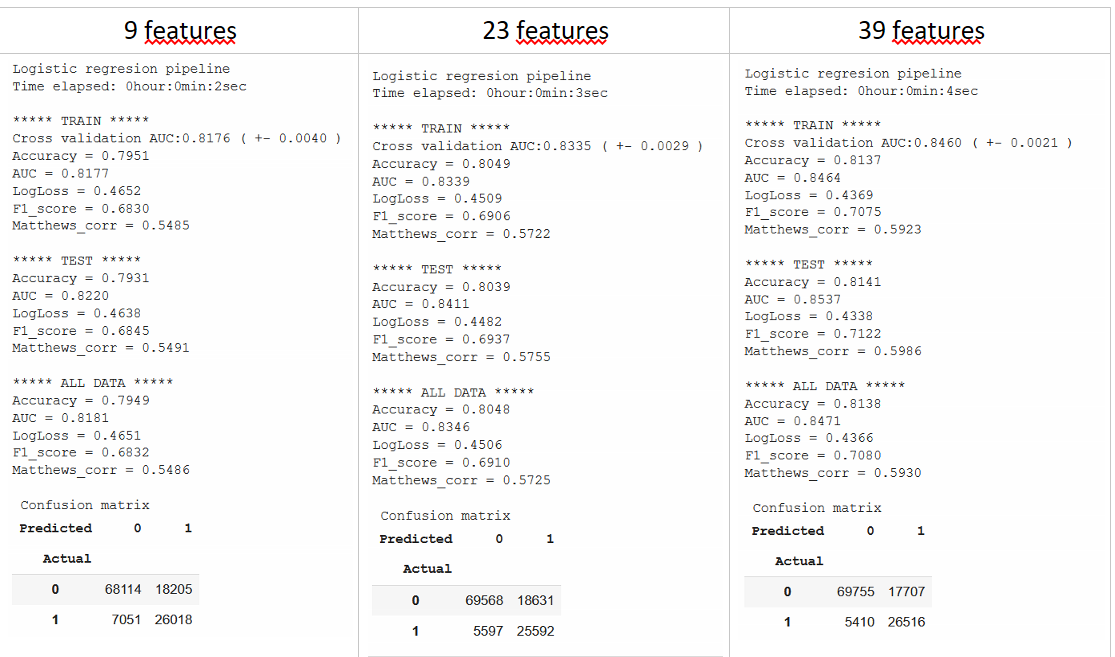

### XGboost

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models. 

In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. Each tree learns from its predecessors and updates the residual errors. Hence, the tree that grows next in the sequence will learn from an updated version of the residuals.

In [0]:
### Libraries
import xgboost as xgb
from xgboost import XGBClassifier

### XG Boosting with stratified CV and GridSearch
def f_xgboost_grid(X,y,params):
  tic()     
  
  xgbmodel=XGBClassifier()
  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'

  kfold = model_selection.StratifiedShuffleSplit(n_splits=5, random_state=15)
  grid_xgboost = GridSearchCV(estimator = xgbmodel, 
                     param_grid = params, 
                     scoring = scoring,
                     cv = kfold,
                     n_jobs=3, 
                     refit = refit,
                     verbose = 1)
    
  model_xgboost = grid_xgboost.fit(X,y)
  
  results_xgboost=pd.DataFrame(model_xgboost.cv_results_)
  print(results_xgboost.head().T)
  tac() # time elapsed
      
  return model_xgboost

# parameters

params={'base_score': [0.8], 
         'booster': ['gbtree'],
         'colsample_bylevel': [1], 
         'colsample_bytree': [0.8], 
         'gamma': [0,0.02,0,5],
         'learning_rate': [0.01,0.02,0.05], 
         'max_depth': [3,6,8],
         'min_child_weight': [1],
         'missing': [None],
         'n_estimators': [400],
         'n_jobs': [-1], 
         'objective': ['binary:logistic'],
         'random_state': [15], 
         'reg_alpha': [0.01,0.02,0.05], 
         'reg_lambda': [0.01,0.02,0.05],
         'scale_pos_weight': [1],
         'subsample': [0.9]}  

model_xgboost = f_xgboost_grid(X_train,y_train,params)

In [0]:
# print metrics

print('\n***** TRAIN *****')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,model_xgboost)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,model_xgboost)
    
print('\n***** ALL DATA *****')
y_pred_xgboost,y_prob_xgboost=clf_metrics(X,y,model_xgboost)

print('\n Confusion matrix')
pd.crosstab(y_pred_xgboost, y, rownames=['Actual'], colnames=['Predicted'])

Feature importance

In [0]:
# Plot importance
fig, ax = plt.subplots(figsize=(14, 12))
xgb.plot_importance(model_xgboost.best_estimator_,ax=ax)

### LightGBM

LighGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.


XGBoost applies level-wise tree growth whereas LightGBM applies leaf-wise tree growth. This makes LightGBM faster.


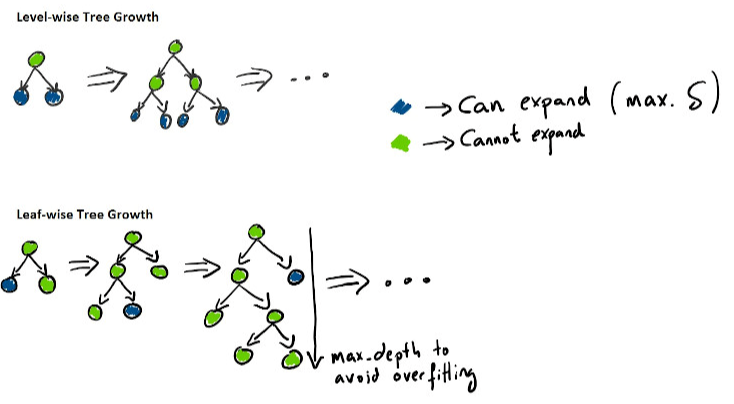

In [0]:
# Libraries
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

### LightGBM using stratified cross validation and GridSearch

def light_LGBM(X,y,param_grid):
  tic()
  seed=15
  indexes_of_categories=[]
    
  lbl = preprocessing.LabelEncoder()
    
  for i in range(X.shape[1]):
      if X_train.dtypes[i]=='object':
          indexes_of_categories.append(i)
          lbl.fit(X.iloc[:,i])
          X.iloc[:,i]=lbl.transform(X.iloc[:,i])
        
  gkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
     
  lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary') 

  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'
     
  gsearch = GridSearchCV(estimator=lgb_estimator, 
                         param_grid=param_grid, 
                         cv=gkf,scoring=scoring,
                         refit=refit,
                         verbose = 2)
    
 
  lightgbm_model = gsearch.fit(X=X, y=y)
    
    
  print('Best parameters:',str(lightgbm_model.best_params_))
  tac()
    
  return lightgbm_model


param_grid = {
'num_leaves': [50,70,80],
'learning_rate':[0.1],
'min_data_in_leaf': [25],
'lambda_l1': [0],
'lambda_l2': [0],
'max_depth': [7],
'n_estimators':[100,200,400]
'num_iterations':[50,100]
}  

lightgbm_model = light_LGBM(X,y,param_grid)

In [0]:
# print metrics

print('\n***** TRAIN *****')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,lightgbm_model)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,lightgbm_model)
    
print('\n***** ALL DATA *****')
y_pred_lgb,y_prob_lgb=clf_metrics(X,y,lightgbm_model)

print('\n Confusion matrix')
pd.crosstab(y_pred_lgb, y, rownames=['Actual'], colnames=['Predicted'])

### Neural network

Artificial neural networks are constructed with simple elements called neurons, which take a real value, multiply it by a weight and run a nonlinear activation function. Building several layers of neurons, each of them receives some of the input variables, passing its results to the following layers, the network can learn very complex functions. A neural network is able to learn the form of any function, given enough computational power.

In [0]:
def f_MLPClass_grid(X,y,param_grid):
  tic() #time mesure
  seed = 15
  scoring='roc_auc'
  sscaler = preprocessing.StandardScaler()
  mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
  kfold = model_selection.StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)
  
  #pipe_MLPClass = make_pipeline('sscaler',sscaler,'log_reg',log_reg)
  pipe_MLPClass = Pipeline([
    ('sscaler',sscaler),
    ('mlp',mlp)])
  
  CV_MLPClass = GridSearchCV(pipe_MLPClass,param_grid, cv=kfold)
  
  model_MLPClass=pipe_MLPClass.fit(X,y)
  tac()
  return model_MLPClass,results_MLPClass

param_grid = {
'hidden_layer_sizes': [[15],[10,10],[5,5,5]]
} 

model_MLPClass,results_MLPClass = f_MLPClass_grid(X_train,y_train,param_grid)

In [0]:
# print metrics

print('\n***** TRAIN *****')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,model_MLPClass)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,model_MLPClass)
    
print('\n***** ALL DATA *****')
y_pred_MLPClass,y_prob_MLPClass=clf_metrics(X,y,model_MLPClass)

print('\n Confusion matrix')
pd.crosstab(y_pred_MLPClass, y, rownames=['Actual'], colnames=['Predicted'])
#MLPClass_model.best_params_